In [153]:
import sys
import pandas as pd
import numpy as np
from numpy import mean
import time
import imdb
from datetime import datetime
import calendar
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
plt.style.use('ggplot')
pd.options.mode.chained_assignment = None  # default='warn'

In [154]:
import re

#function that uses a regex to extract data we need from various cols in dataset
def extractData(str):
    return re.findall("'name': \'(.+?)\'", str)

In [155]:
#function to get past movie success
def calcPastSuccess(movie, ia):
    start_time = time.time()
    for i in range(8):
        actor = movie['cast'][i]
        filmList = ia.get_person_filmography(actor.getID())['data']['filmography'][0]
        filmography = filmList.get('actor')
        if filmography is None:
            filmography = filmList.get('actress')

        totalRating = 0
        totalBO = 0
        movieCount = 0
        accMovieCount = 0
        for film in filmography:
            if film['kind'] == 'movie':
                film = ia.get_movie(film.getID())
                rating = film.get("rating")
                boxOffice = film.get("box office")
                if boxOffice is not None :
                    gross = boxOffice.get('Cumulative Worldwide Gross')
                else:
                    gross = None

                accMovieCount += 1
                if rating is not None and gross is not None:
                    totalRating += float(rating)
                    gross = gross.split(' ')[0][1:].replace(',','')
                    totalBO += float(gross)
                    movieCount += 1
        if movieCount > 0:
            AvgIMDbScore = totalRating/movieCount
            AvgBO = totalBO/movieCount
        else:
            AvgIMDbScore = 0
            AvgBO = 0
        print("Statistics for", actor)
        print('Number of Movies used in formula: ',movieCount)
        print('Number of Movies Total: ', accMovieCount)
        print("Average IMDb Score: ", AvgIMDbScore)
        pastIMDbFormula = AvgIMDbScore - 10 * (1/3)**movieCount
        pastBoxOfficeFormula = 10* (AvgBO / 100000000) - 10 * (1/3)**movieCount

        print('IMDb Weighted Average Rating for: ', pastIMDbFormula)
        print('Box Office Weighted Average for: ', pastBoxOfficeFormula)
        print("--- %s minutes ---" % ((time.time() - start_time)/60))
        print()

In [156]:
#Load in the data
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
#Look at all of the columns
print(train.columns)

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue'],
      dtype='object')


In [157]:
#Drop columns we will not be using and inspect the head of df
train = train.drop(columns=[ 'homepage', 'poster_path', 'original_title', 'overview','tagline','Keywords'])
train.head(10)

,id,belongs_to_collection,budget,genres,imdb_id,original_language,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,title,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",tt2637294,en,6.575393,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Hot Tub Time Machine 2,"[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",tt0368933,en,8.248895,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Princess Diaries 2: Royal Engagement,"[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",tt2582802,en,64.299990,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Whiplash,"[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",tt1821480,hi,3.174936,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Kahaani,"[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",tt1380152,ko,1.148070,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,Marine Boy,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970
5,6,NaN,8000000,"[{'id': 16, 'name': 'Animation'}, {'id': 12, '...",tt0093743,en,0.743274,NaN,NaN,8/6/87,83.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Pinocchio and the Emperor of the Night,"[{'cast_id': 6, 'character': 'Pinocchio (voice...","[{'credit_id': '52fe46f49251416c9106558b', 'de...",3261638
6,7,NaN,14000000,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",tt0431021,en,7.286477,"[{'name': 'Ghost House Pictures', 'id': 768}, ...","[{'iso_3166_1': 'US', 'name': 'United States o...",8/30/12,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Possession,"[{'cast_id': 23, 'character': 'Clyde', 'credit...","[{'credit_id': '52fe4981c3a368484e12ee29', 'de...",85446075
7,8,NaN,0,"[{'id': 99, 'name': 'Documentary'}]",tt0391024,en,1.949044,NaN,NaN,1/15/04,84.0,"[{'iso_639_1': 'ar', 'name': 'العربية'}, {'iso...",Released,Control Room,"[{'cast_id': 2, 'character': 'Himself', 'credi...","[{'credit_id': '52fe47a69251416c750a0daf', 'de...",2586511
8,9,"[{'id': 256377, 'name': 'The Muppet Collection...",0,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",tt0117110,en,6.902423,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/16/96,100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Muppet Treasure Island,"[{'cast_id': 1, 'character': 'Long John Silver...","[{'credit_id': '52fe43c89251416c7501deb3', 'de...",34327391
9,10,NaN,6000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",tt0310281,en,4.672036,"[{'name': 'Castle Rock Entertainment', 'id': 97}]","[{'iso_3166_1': 'US', 'name': 'United States o...",4/16/03,91.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A Mighty Wind,"[{'cast_id': 24, 'character': 'Jonathan Steinb...","[{'credit_id': '52fe45609251416c750545b3', 'de...",18750246


In [158]:
print(train.shape)

(3000, 17)


In [159]:
print(train.describe())

                id        budget   popularity      runtime       revenue
count  3000.000000  3.000000e+03  3000.000000  2998.000000  3.000000e+03
mean   1500.500000  2.253133e+07     8.463274   107.856571  6.672585e+07
std     866.169729  3.702609e+07    12.104000    22.086434  1.375323e+08
min       1.000000  0.000000e+00     0.000001     0.000000  1.000000e+00
25%     750.750000  0.000000e+00     4.018053    94.000000  2.379808e+06
50%    1500.500000  8.000000e+06     7.374861   104.000000  1.680707e+07
75%    2250.250000  2.900000e+07    10.890983   118.000000  6.891920e+07
max    3000.000000  3.800000e+08   294.337037   338.000000  1.519558e+09


In [160]:
#replace all NA values to empty strings so we can extract data cleanly
train.genres = train.genres.fillna("")
train.production_companies = train.production_companies.fillna("")
train.production_countries = train.production_countries.fillna("")
train.spoken_languages = train.spoken_languages.fillna("")

In [161]:
#use helper function to extract data from necessary features
train['genres_reform'] = train['genres'].apply(lambda x: extractData(x))
train['production_companies_reform'] = train['production_companies'].apply(lambda x: extractData(x))
train['production_countries_reform'] = train['production_countries'].apply(lambda x: extractData(x))
train['spoken_languages_reform'] = train['spoken_languages'].apply(lambda x: extractData(x))

In [162]:
train.head()

,id,belongs_to_collection,budget,genres,imdb_id,original_language,popularity,production_companies,production_countries,release_date,...,spoken_languages,status,title,cast,crew,revenue,genres_reform,production_companies_reform,production_countries_reform,spoken_languages_reform
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",tt2637294,en,6.575393,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Hot Tub Time Machine 2,"[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651,[Comedy],"[Paramount Pictures, United Artists, Metro-Gol...",[United States of America],[English]
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",tt0368933,en,8.248895,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Princess Diaries 2: Royal Engagement,"[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435,"[Comedy, Drama, Family, Romance]",[Walt Disney Pictures],[United States of America],[English]
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",tt2582802,en,64.299990,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Whiplash,"[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000,[Drama],"[Bold Films, Blumhouse Productions, Right of W...",[United States of America],[English]
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",tt1821480,hi,3.174936,,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Kahaani,"[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000,"[Thriller, Drama]",[],[India],"[English, हिन्दी]"
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",tt1380152,ko,1.148070,,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,...,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,Marine Boy,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970,"[Action, Thriller]",[],[South Korea],[한국어/조선말]


In [163]:
# you can easily index through it now, like so:
print(train['genres_reform'][1])
for genre in train['genres_reform'][1]:
    print(genre)

['Comedy', 'Drama', 'Family', 'Romance']
Comedy
Drama
Family
Romance


In [164]:
#making a copy so i can play with stuff and show you how i've done some things without changing the real dataset
df = train.copy(deep=True)

In [165]:
# Will likely make this another separate file as a helper function, can be used for several of the features
def unpackCol(list, df):
    for i in range(len(df)):
        for name in list[i]:
            if name not in df.columns:
                df[name] = 0
            df[name][i] = 1
    return df

In [166]:
# stripping the 'tt' from the idmb id, only used in url and easier to get movies without it
df['imdb_id'] = df['imdb_id'].str[2:]
df['imdb_id']

0       2637294
1       0368933
2       2582802
3       1821480
4       1380152
         ...   
2995    0109403
2996    2364975
2997    0116908
2998    0343135
2999    1600195
Name: imdb_id, Length: 3000, dtype: object

Belongs to Collection

In [167]:
# here is a quick line to sort out the collection stuff
df.belongs_to_collection = df.belongs_to_collection.apply(lambda x: 1 if type(x) == str else 0)

In [168]:
print(df.belongs_to_collection)
print()
print('Total movies in collections:', sum(df.belongs_to_collection))
print('Total movies not in collections:', (df.belongs_to_collection == 0).sum(axis=0))

0       1
1       1
2       0
3       0
4       0
       ..
2995    0
2996    0
2997    0
2998    0
2999    0
Name: belongs_to_collection, Length: 3000, dtype: int64

Total movies in collections: 604
Total movies not in collections: 2396


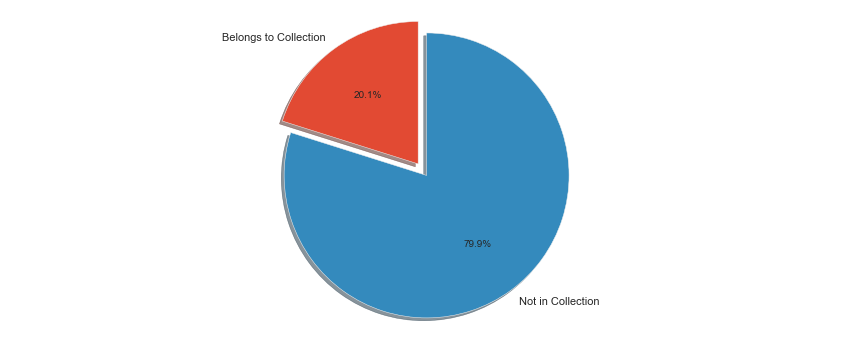

In [169]:
# plotting belongs to collection data
labels = 'Belongs to Collection', 'Not in Collection'
btc_1 = [sum(df.belongs_to_collection), (df.belongs_to_collection == 0).sum(axis=0)]
explode = (0.1, 0)
# cs=['#66b3ff', '#ff9999']

fig, ax = plt.subplots()
ax.pie(btc_1, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal') # ensures chart is a circle

plt.show()

From a total of 3000 data points, 604 or 20.1% were a part of a collection of films, while the other 2396 or 79.9% were not. Belonging to a collection has the potential to be an important feature when predicting revenue as customers may be more likely to pay for a movie-going experience when it is the next iteration of a series into which they have already invested time and money. The origin of serial media is largely accredited to The Pickwick Papers, written by Charles Dickens in 1836, and has since boomed all the way into the 21st century. Given the current and historic popularity of the format, it is hypothesized that belonging to a collection will indicate a positive correlation with revenue.

In [170]:
avg = mean(df.revenue)
btc_2 = df.belongs_to_collection

Genres

In [171]:
#example of using it to unpack the genres 
df = unpackCol(df['genres_reform'], df)

In [172]:
#here's what it did
print(df.columns)
print()
print(df['Drama'])
print()
# This total number lines up with what other people had too for amount of dramas, so assuming it is correct
print('Total number of Dramas: ', sum(df['Drama']))

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'imdb_id',
       'original_language', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'title', 'cast', 'crew', 'revenue', 'genres_reform',
       'production_companies_reform', 'production_countries_reform',
       'spoken_languages_reform', 'Comedy', 'Drama', 'Family', 'Romance',
       'Thriller', 'Action', 'Animation', 'Adventure', 'Horror', 'Documentary',
       'Music', 'Crime', 'Science Fiction', 'Mystery', 'Foreign', 'Fantasy',
       'War', 'Western', 'History', 'TV Movie'],
      dtype='object')

0       0
1       1
2       1
3       1
4       0
       ..
2995    0
2996    1
2997    0
2998    0
2999    0
Name: Drama, Length: 3000, dtype: int64

Total number of Dramas:  1531


In [173]:
# here is my lambda for featurizing the genre data - works like a dream with the reformed data! JSON be darned
df_test = df['genres_reform'].apply(frozenset).to_frame(name='genre')
for genre in frozenset.union(*df_test.genre):
    df_test[genre] = df_test.apply(lambda _: int(genre in _.genre), axis=1)
df_test.head()

,genre,Family,Mystery,Foreign,Adventure,Fantasy,War,History,Romance,Music,...,Animation,Action,Western,Horror,Drama,Thriller,TV Movie,Comedy,Crime,Documentary
0,(Comedy),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,"(Drama, Family, Comedy, Romance)",1,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
2,(Drama),0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,"(Thriller, Drama)",0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
4,"(Thriller, Action)",0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0


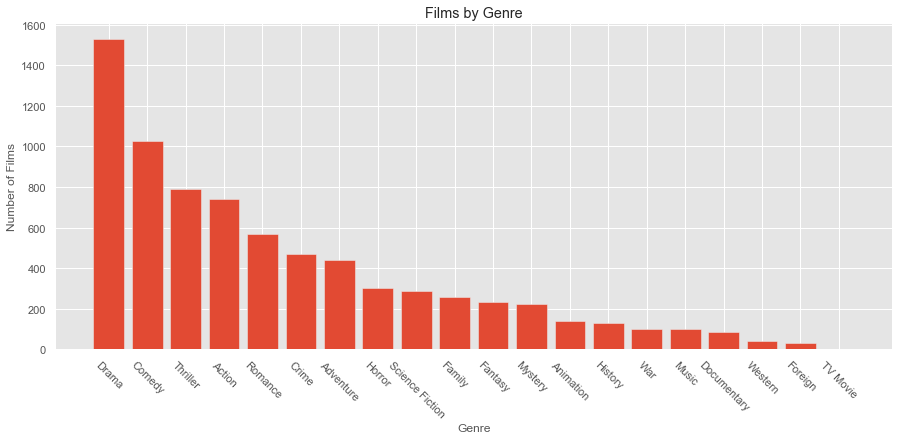

In [174]:
# plotting genres in order of number of instances in the train.csv dataset
bx = ['Drama', 'Comedy', 'Thriller', 'Action',
       'Romance', 'Crime', 'Adventure', 'Horror', 'Science Fiction', 'Family',
       'Fantasy', 'Mystery', 'Animation', 'History', 'War', 'Music',
       'Documentary', 'Western', 'Foreign', 'TV Movie']
number = [(sum(df['Drama'])), (sum(df['Comedy'])), (sum(df['Thriller'])), (sum(df['Action'])), 
            (sum(df['Romance'])), (sum(df['Crime'])), (sum(df['Adventure'])), 
            (sum(df['Horror'])), (sum(df['Science Fiction'])), (sum(df['Family'])),
            (sum(df['Fantasy'])), (sum(df['Mystery'])), (sum(df['Animation'])),
            (sum(df['History'])), (sum(df['War'])), (sum(df['Music'])), (sum(df['Documentary'])),
            (sum(df['Western'])), (sum(df['Foreign'])), (sum(df['TV Movie']))]

# size and positioning
bx_pos = [i for i, _ in enumerate(bx)]
plt.figure(figsize=(15, 6))

# plot
plt.bar(bx_pos, number)
plt.xlabel("Genre")
plt.ylabel("Number of Films")
plt.title("Films by Genre")
plt.xticks(bx_pos, bx, rotation=-45)

plt.show()

Genres of movies follow certain trends in popularity; such as the latest boom of superhero movies originating in the 1990s with 20th Century Fox's X-Men series. Although superhero films have been around since at least 1978 with Richard Donner's Superman, the recent trend has helped define the film industry over the past two decades. As such, the importance of genre for determining the revenue of a film (and likewise predicting future success) could be highly useful given the sometimes nebulous patterns of viewership.

In [175]:
# list of film genres by order of number of films in set
print(df['Drama'].sum())
print(df['Comedy'].sum())
print(df['Thriller'].sum())
print(df['Action'].sum())
print(df['Romance'].sum())
print(df['Crime'].sum())
print(df['Adventure'].sum())
print(df['Horror'].sum())
print(df['Science Fiction'].sum())
print(df['Family'].sum())
print(df['Fantasy'].sum())
print(df['Mystery'].sum())
print(df['Animation'].sum())
print(df['History'].sum())
print(df['War'].sum())
print(df['Music'].sum())
print(df['Documentary'].sum())
print(df['Western'].sum())
print(df['Foreign'].sum())
print(df['TV Movie'].sum())

1531
1028
789
741
571
469
439
301
290
260
232
225
141
132
100
100
87
43
31
1


In the case of genres, we see a near logarithmic function from Drama (1531 films) to TV Movies (1). It is assumed that this dataset is representative of broader filmography trends for the purposes of constructing hypotheses about the data. The more popular genres should typically see a likewise correlation in revenue given the increased popularity. However, it is worth considering the unique attraction of 'rare genre' films. Musicals like La La Land grossed S446.1 million for its Box Office total and did so with only a $30 million budget. Therefore, the possibility for outliers or even inverse hypotheses are worth considering.

Popularity

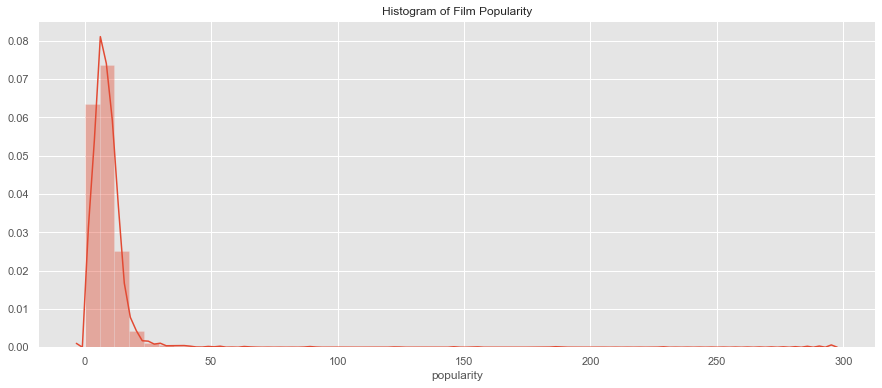

In [176]:
# plotting popularity
sns.distplot(df['popularity'], kde=True)
sns.set(rc={'figure.figsize':(15,6)})
plt.title('Histogram of Film Popularity')
plt.show();

In [177]:
print(df['popularity'].describe())

count    3000.000000
mean        8.463274
std        12.104000
min         0.000001
25%         4.018053
50%         7.374861
75%        10.890983
max       294.337037
Name: popularity, dtype: float64


Popularity is likely to be a significant feature in prediting revenue outcome given the importance of popularity for movie viewership (this is of course contingent upon popularity refering to the 'hype' surrounding a film and not the post-release ratings - if the later than popularity should more directly map to revenue in theory). Because of the more popularity is a good thing for marketing, and thus increased ticket sales, it is hypothesized that popularity and revenue will have a positive correlation. 

Above it is seen that of the 3000 films in the dataset the average popularity was an 8.46 with a minimum of 0.00 and a max of 294.34. The histogram reveals that the bulk of the films fall between a popularity score of 0 and 25, with sparse highly popular outliers. Dealing with these outliers will be addressed later.

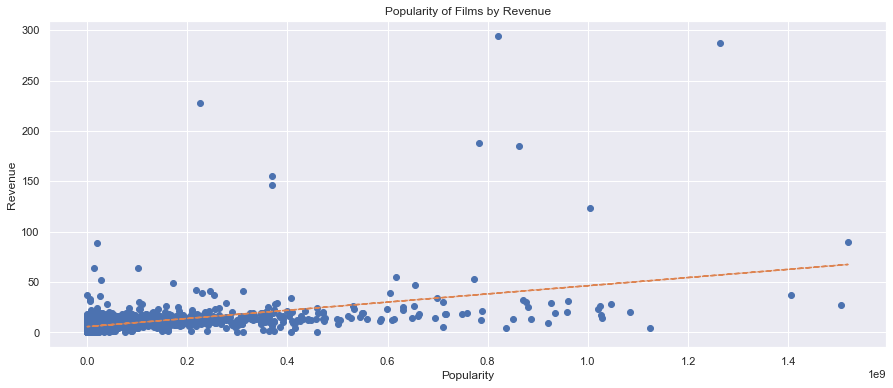

In [178]:
# plotting popularity and revenue
cx = df['revenue']
pop = df['popularity']
plt.plot(cx, pop, 'o')
plt.ylabel("Revenue")
plt.xlabel("Popularity")
plt.title("Popularity of Films by Revenue")

z = np.polyfit(cx, pop, 1)
p = np.poly1d(z)
plt.plot(cx, p(cx), "--");

In comparing popularity against revenue, there is an overall positive correlation. This is to be expected given the influence of popularity on a film's monetary success via more developed viewership. Further investigation should be conducted by playing around with the outlier values; notably, certain highly popular films do not see concurrently higher revenue, which leads to the conclusion that popularity is not a perfect indicator of a movie's revenue.

Production Companies

In [179]:
# new feature for a count of the number of production studios
df['num_studios'] = df.production_companies_reform.apply(lambda x: len(x))
print(df['num_studios'])

0       3
1       1
2       3
3       0
4       0
       ..
2995    2
2996    2
2997    3
2998    2
2999    6
Name: num_studios, Length: 3000, dtype: int64


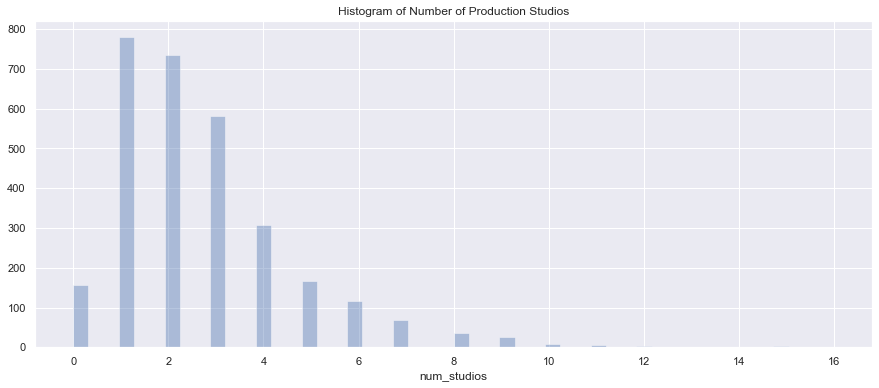

In [180]:
# plotting films by number of production studios
sns.distplot(df['num_studios'], kde=False)
sns.set(rc={'figure.figsize':(15,6)})
plt.title('Histogram of Number of Production Studios')
plt.show();

Most movies have between 1 and 4 production studios, with fewer films having higher numbers and some even with 0 studio partners (independent films). However, given only the sheer number of production studios it is difficult to produce a reasonable hypothesis regarding the box office success of the film. Instead, determining the larger, more established, or otherwise previously successful production studios and applying those findings toward whether or not the dataset films in question have said studios would be a more useful way to analyze the impact of production companies.

Release Date

In [181]:
# release date data manipulation
# naming a date-specific dataframe for housekeeping
df_date = df['release_date']

# converting to datetime format, with .dt used for accessing quantities
df_date = pd.to_datetime(df_date)
df_date.dt
print(df_date)

0      2015-02-20
1      2004-08-06
2      2014-10-10
3      2012-03-09
4      2009-02-05
          ...    
2995   1994-04-22
2996   2013-03-28
2997   1996-10-11
2998   2004-01-16
2999   2011-09-22
Name: release_date, Length: 3000, dtype: datetime64[ns]


In [182]:
# possible output options
print(df_date.dt.year) # absolutely necessary
print(df_date.dt.dayofweek) # friday night hits!
print(df_date.dt.dayofyear) # it's a christmas miracle
print(df_date.dt.weekofyear) # idk might be interesting

0       2015
1       2004
2       2014
3       2012
4       2009
        ... 
2995    1994
2996    2013
2997    1996
2998    2004
2999    2011
Name: release_date, Length: 3000, dtype: int64
0       4
1       4
2       4
3       4
4       3
       ..
2995    4
2996    3
2997    4
2998    4
2999    3
Name: release_date, Length: 3000, dtype: int64
0        51
1       219
2       283
3        69
4        36
       ... 
2995    112
2996     87
2997    285
2998     16
2999    265
Name: release_date, Length: 3000, dtype: int64
0        8
1       32
2       41
3       10
4        6
        ..
2995    16
2996    13
2997    41
2998     3
2999    38
Name: release_date, Length: 3000, dtype: int64


In [183]:
print(df.release_date.describe())
print()
print(df_date.dt.year.describe())

count        3000
unique       2398
top       9/10/10
freq            5
Name: release_date, dtype: object

count    3000.000000
mean     2004.779667
std        15.664767
min      1970.000000
25%      1995.000000
50%      2006.000000
75%      2012.000000
max      2069.000000
Name: release_date, dtype: float64


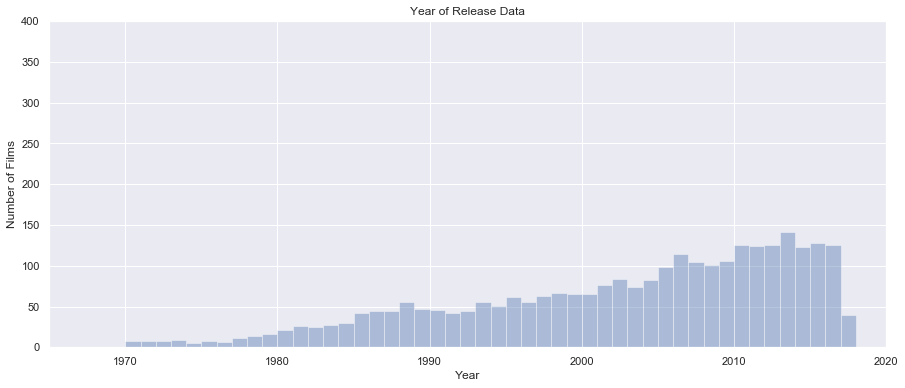

In [184]:
# plotting the year of the films release
fig, dx = plt.subplots()
sns.distplot(df_date.dt.year, bins=99, kde=False)
sns.set(rc={'figure.figsize':(15, 6)})

dx.set(xlim=(1965, 2020),ylim=(0,400))
dx.set_xlabel("Year")
dx.set_ylabel("Number of Films")
dx.set_title("Year of Release Data")

# dx.set_xticklabels(dx.get_xticklabels(), rotation=-45)

plt.show();

The plot for year of release for the dataset shows a general increase in number of films as time progresses, which makes sense for a growing/maturing industry. While mostly linear, there are several 

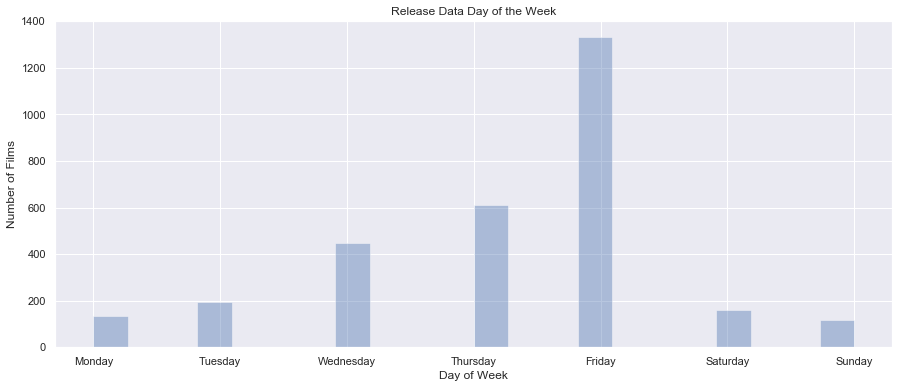

In [187]:
# plotting the films release day of the week
fig, ex = plt.subplots()
sns.distplot(df_date.dt.dayofweek, kde=False)
sns.set(rc={'figure.figsize':(15,6)})

ex.set_xlabel("Day of Week")
ex.set_ylabel("Number of Films")
ex.set_title("Release Data Day of the Week")

labels = [item.get_text() for item in ex.get_xticklabels()]
labels[1] = 'Monday'
labels[2] = 'Tuesday'
labels[3] = 'Wednesday'
labels[4] = 'Thursday'
labels[5] = 'Friday'
labels[6] = 'Saturday'
labels[7] = 'Sunday'

ex.set_xticklabels(labels)

plt.show();

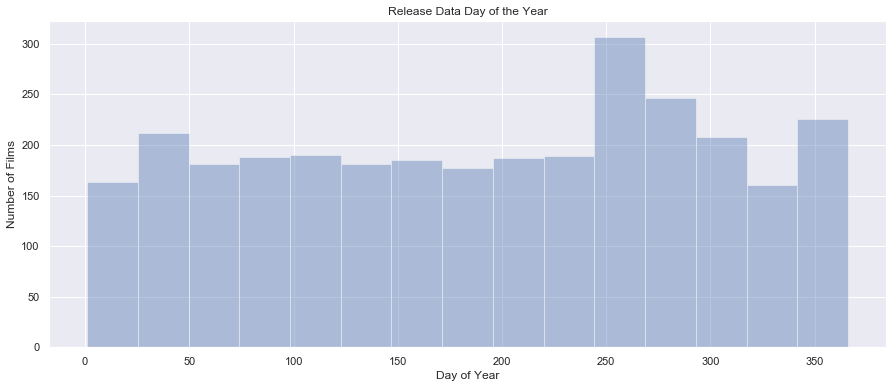

In [105]:
# plotting the films release day of the year
fig, fx = plt.subplots()
sns.distplot(df_date.dt.dayofyear, kde=False)
sns.set(rc={'figure.figsize':(15,6)})

fx.set_xlabel("Day of Year")
fx.set_ylabel("Number of Films")
fx.set_title("Release Data Day of the Year")

plt.show();

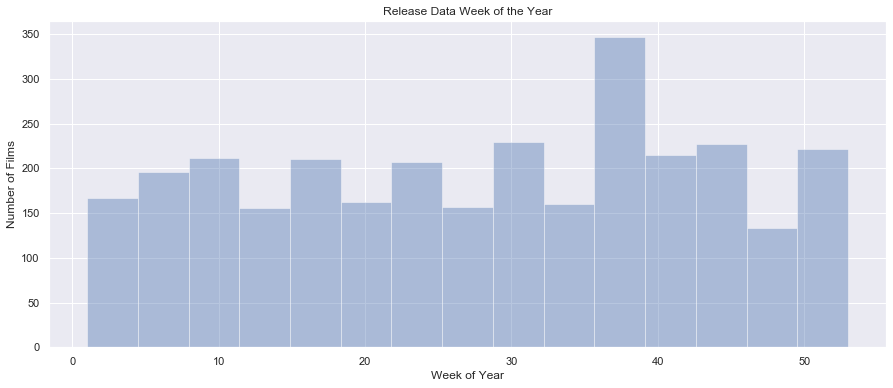

In [106]:
# plotting the films release week of the year
fig, fx = plt.subplots()
sns.distplot(df_date.dt.weekofyear, kde=False)
sns.set(rc={'figure.figsize':(15,6)})

fx.set_xlabel("Week of Year")
fx.set_ylabel("Number of Films")
fx.set_title("Release Data Week of the Year")

plt.show();

Spoken Languages

In [107]:
# new feature for a count of the number of spoken languages
df['num_languages'] = df.spoken_languages_reform.apply(lambda x: len(x))

Crew (tbd)